In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from RGVSC import *
from typing import List, Dict

In [2]:
# 参数设置
I_val = 0.6
alpha_val = 0.7
D_val = 0.06
epsilon_val = 1
tl_order = 5
rg_order = 5

In [3]:
I, alpha, D = sp.symbols('I alpha D')
x, y = sp.symbols('x y')
z, w = sp.symbols('z w')
t = sp.symbols('t')
epsilon = sp.symbols('epsilon')
a1, a2, b1, b2 = sp.symbols('a1 a2 b1 b2')
z0 = sp.symbols('a')  # 不稳定方向初始扰动幅值
w0 = 0   # 稳定方向初始扰动幅值
t0 = sp.symbols('t0')
a_t0 = sp.Function('a')(t0)
vec_unstable_sym = sp.Matrix([a1,a2])
vec_stable_sym = sp.Matrix([b1,b2])
# 鞍点表达式
xs_sym = sp.pi - sp.asin(I)
ys_sym = 0.0
# 鞍点数值
xs_val = float(xs_sym.subs(I, I_val).evalf())
ys_val = 0.0

In [4]:
params = {
    alpha:alpha_val,
    I: I_val,
    D: D_val,
    xs_sym:xs_val,
    ys_sym:ys_val,
    epsilon:epsilon_val,
}

In [5]:
def original_func(t, g):
    x, y = g
    return [-y, -I + sp.sin(x) + (alpha * sp.cos(x) - D) * y]

def taylor_func(t, g, tl_order=tl_order, original_func=original_func, xs_sym=xs_sym, ys_sym=ys_sym):
    x, y = g
    f1_expr, f2_expr = original_func(t, g)
    taylor_f1expr = sp.series(f1_expr, y, ys_sym, n=tl_order+1).removeO().simplify()
    taylor_f2expr = sp.series(f2_expr, x, xs_sym, n=tl_order+1).removeO().simplify()
    return [taylor_f1expr, taylor_f2expr]

def sub_func(item, params):
    return item.subs(params)

def original_system(t, g, original_func=original_func, params=params):
    return [sub_func(item, params) for item in original_func(t, g)]

def taylor_system(t, g, taylor_func=taylor_func, params=params, tl_order=tl_order):
    return [sub_func(item, params) for item in taylor_func(t, g, tl_order=tl_order)]

def compute_sym_Jacobian(t, g, original_func, params):
    x, y = g
    dx_dt, dy_dt = original_system(t, g, original_func, params)
    J = sp.Matrix([
        [sp.diff(dx_dt, x), sp.diff(dx_dt, y)],
        [sp.diff(dy_dt, x), sp.diff(dy_dt, y)]
    ])
    return J

def convert_sym_to_num_Jacobian(J_sym, params):
    J_sym = J_sym.subs({x:xs_sym,y:ys_sym})
    J_num = J_sym.subs(params)
    J_num = np.array(J_num).astype(float)
    return J_num

def compute_num_Jacobian(t, g, original_func, params):
    J_sym = compute_sym_Jacobian(t, g, original_func, params)
    J_num = convert_sym_to_num_Jacobian(J_sym, params)
    return J_num

def compute_eigenvectors(J_num):
    eigvals, eigvecs = np.linalg.eig(J_num)
    idx = np.argsort(eigvals)
    eigvecs = eigvecs[:, idx]
    vec_stable = eigvecs[:, 0].real / np.linalg.norm(eigvecs[:, 0].real)
    vec_unstable = eigvecs[:, 1].real / np.linalg.norm(eigvecs[:, 1].real)
    return vec_stable, vec_unstable

def compute_format_eigenvectors(J_num):
    """
    计算雅可比矩阵的稳定/不稳定特征向量，并格式化为 [x, 1] 形式
    
    Args:
        J_num (np.ndarray): 2x2 雅可比矩阵
        
    Returns:
        tuple: (vec_stable, vec_unstable) 格式化的特征向量对
    """
    # 计算特征值和特征向量
    eigvals, eigvecs = np.linalg.eig(J_num)
    
    # 按特征值实部排序 (稳定方向: 实部最小，不稳定方向: 实部最大)
    idx = np.argsort(eigvals.real)
    eigvecs_sorted = eigvecs[:, idx].real  # 取实部并排序
    
    def format_vector(vec):
        """将特征向量格式化为 [x, 1] 形式"""
        # 确保第二个分量不为零，否则保持原向量
        if np.abs(vec[1]) > 1e-10:  # 浮点数精度阈值
            # 调整方向使第二个分量为正
            if vec[1] < 0:
                vec = -vec
            scaled_vec = vec / vec[1]
            return np.array([scaled_vec[0], 1.0])
        else:
            # 特殊情况：第二分量为零时保持原方向
            return vec / np.linalg.norm(vec)  # 归一化
    
    # 提取并格式化稳定/不稳定向量
    vec_stable = format_vector(eigvecs_sorted[:, 0])
    vec_unstable = format_vector(eigvecs_sorted[:, 1])
    
    return vec_stable, vec_unstable

def transformed_system(t, zw, dxy_dt, vec_stable, vec_unstable, xs_val=xs_val, ys_val=ys_val):
    """
    转换到特征向量坐标系后的系统方程
    :param t: 时间（未使用，但保留以兼容ODE求解器）
    :param zw: 新坐标系下的状态变量 [z, w]
    :param vec_stable: 稳定特征向量
    :param vec_unstable: 不稳定特征向量
    :param original_system: 原系统方程函数，形式为 func(t, g) -> [dx_dt, dy_dt]
    :param xs_val: 原系统的平衡点x坐标
    :return: 新坐标系下的导数 [dz_dt, dw_dt]
    """
    # 构建坐标变换矩阵
    P = np.column_stack((vec_unstable, vec_stable))
    P_inv = np.linalg.inv(P)
    
    # 计算原系统偏移量
    z, w = zw
    delta_x = vec_unstable[0] * z + vec_stable[0] * w
    delta_y = vec_unstable[1] * z + vec_stable[1] * w
    
    # 获取原系统坐标
    x_zw = xs_val + delta_x
    y_zw = ys_val + delta_y
    
    dzw_dt = P_inv @ [sub_func(item, params={x:x_zw,y:y_zw}) for item in dxy_dt]
    return dzw_dt

In [6]:
J_sym = compute_sym_Jacobian(t,g=[x,y],original_func=original_func,params=params)
J_num = convert_sym_to_num_Jacobian(J_sym,params=params)
vec_stable_val, vec_unstable_val = compute_format_eigenvectors(J_num)
params.update({
    a1:vec_unstable_val[0],
    a2:vec_unstable_val[1],
    b1:vec_stable_val[0],
    b2:vec_stable_val[1], 
})


In [7]:
def transform_dxy_to_dzw_sym(dxy_dt, vec_unstable_sym=vec_unstable_sym,
                            vec_stable_sym=vec_stable_sym, 
                            xs_sym=xs_sym, 
                            ys_sym=ys_sym):
    # 使用SymPy水平堆叠构建变换矩阵P
    P = sp.Matrix.hstack(vec_unstable_sym, vec_stable_sym)
    P_inv = P.inv()
    
    # 提取特征向量的分量（假设vec_unstable_sym和vec_stable_sym为列向量）
    a1, a2 = vec_unstable_sym
    b1, b2 = vec_stable_sym
    
    # 构建坐标变换关系
    x_zw = (a1 * z + b1 * w) + xs_sym
    y_zw = (a2 * z + b2 * w) + ys_sym
    
    # 替换dxy_dt中的x和y为x_zw和y_zw
    substituted = [expr.subs({x: x_zw, y: y_zw}) for expr in dxy_dt]
    
    # 将替换后的导数转换为向量并进行坐标变换
    substituted_vector = sp.Matrix(substituted)
    dzw_dt = P_inv * substituted_vector
    for i in range(len(dzw_dt)):
        dzw_dt[i] = sp.simplify(dzw_dt[i])
    return dzw_dt


def get_perturbation_equations(
    dzw_dt: List[sp.Expr],
    rg_order: int = 5,
    threshold: float = 1e-15,
    remove_coupling: bool = False
) -> Dict[int, List[sp.Eq]]:
    """
    精确移除当前阶跨变量耦合项的摄动方程生成
    
    Args:
        dzw_dt: [dz/dt, dw/dt] 的表达式列表
        rg_order: 最大重正化群阶数
        threshold: 小量截断阈值
        remove_coupling: 是否移除当前阶跨变量项
        
    Returns:
        精确处理后的摄动方程组字典
    """
    t = sp.symbols('t')
    # 生成系数函数符号
    z_funcs = [sp.Function(f'z{i}')(t) for i in range(1, rg_order+1)]
    w_funcs = [sp.Function(f'w{i}')(t) for i in range(1, rg_order+1)]

    # 构建摄动级数
    z_series = sum(epsilon**i * z_funcs[i-1] for i in range(1, rg_order+1))
    w_series = sum(epsilon**i * w_funcs[i-1] for i in range(1, rg_order+1))

    # 变量替换并展开
    substituted = [
        expr.subs({z: z_series, w: w_series}).expand()
        for expr in dzw_dt
    ]

    equations = {}
    for order in range(1, rg_order+1):
        eqs = []
        for i, expr in enumerate(substituted):
            # 提取当前阶系数
            coeff = expr.coeff(epsilon, order)
            coeff = coeff.replace(
                lambda x: x.is_Float and abs(x) < threshold,
                lambda _: sp.Float(0)
            )
            
            # 确定当前函数和方程类型
            is_z_eq = (i == 0)
            current_func = z_funcs[order-1] if is_z_eq else w_funcs[order-1]
            
            # 精确分离线性项
            linear_terms = 0
            other_terms = 0
            for term in sp.Add.make_args(coeff):
                # 分离包含当前函数的线性项
                if term.has(current_func):
                    ratio = term / current_func
                    if not ratio.has(current_func):
                        linear_terms += ratio * current_func
                        continue
                other_terms += term
            
            # 精确移除当前阶跨变量项
            if remove_coupling:
                # 获取另一变量的当前阶函数
                cross_var_func = w_funcs[order-1] if is_z_eq else z_funcs[order-1]
                # 移除包含该函数的项
                other_terms = other_terms.replace(cross_var_func, 0)
            
            # 构造标准方程
            eq = sp.Eq(
                sp.Derivative(current_func, t) ,
                other_terms.simplify() + linear_terms.simplify()
            )
            eqs.append(eq)
        
        equations[order] = eqs

    return equations

def convert_sym_to_num_Eqations(equations, params):
    equations_num = {order:[] for order in equations.keys()}
    for order, eqs in equations.items():
        equations_num[order].append(eqs[0].subs(params))
        equations_num[order].append(eqs[1].subs(params))
    return equations_num

In [8]:
dxy_dt_tl = taylor_func(t, g=[x,y], 
                        tl_order=tl_order, 
                        original_func=original_func, 
                        xs_sym=xs_sym, 
                        ys_sym=ys_sym)
dzw_dt_sym = transform_dxy_to_dzw_sym(dxy_dt_tl)
dzw_dt_val = sub_func(dzw_dt_sym, params)
dz_dt, dw_dt = dzw_dt_val
dzw_dt_val


Matrix([
[0.214072037938063*w + 0.214072037938063*z - 0.0267962588229219*(0.506615170878591*w - z)**5*(0.42*w + 0.42*z + 0.8) - 0.0852959198738089*(0.506615170878591*w - z)**4*(0.56*w + 0.56*z - 0.6) + 0.217206259879704*(0.506615170878591*w - z)**3*(0.42*w + 0.42*z + 0.8) - 0.414837187412316*(0.506615170878591*w - z)**2*(-0.56*w - 0.56*z + 0.6) - 0.336260500140295*(0.795781982453887*w - 1.57078198245389*z)*(0.42*w + 0.42*z + 0.8)],
[ -0.834072037938063*w - 0.834072037938063*z - 0.0528927287677762*(0.506615170878591*w - z)**5*(0.42*w + 0.42*z + 0.8) - 0.168364322224867*(0.506615170878591*w - z)**4*(0.56*w + 0.56*z - 0.6) + 0.42874014116675*(0.506615170878591*w - z)**3*(0.42*w + 0.42*z + 0.8) - 0.818840830788565*(0.506615170878591*w - z)**2*(-0.56*w - 0.56*z + 0.6) - 0.663739499859705*(0.795781982453887*w - 1.57078198245389*z)*(0.42*w + 0.42*z + 0.8)]])

In [9]:
dzw_dt_sym

Matrix([
[ (b1*(120*D*(a2*z + b2*w) + 120*alpha*sqrt(1 - I**2)*(a2*z + b2*w) + 5*(-I + alpha*sqrt(1 - I**2)*(a2*z + b2*w))*(a1*z + b1*w)**4 + 60*(I - alpha*sqrt(1 - I**2)*(a2*z + b2*w))*(a1*z + b1*w)**2 + (a1*z + b1*w)**5*(I*alpha*(a2*z + b2*w) + sqrt(1 - I**2)) - 20*(a1*z + b1*w)**3*(I*alpha*(a2*z + b2*w) + sqrt(1 - I**2)) + 120*(a1*z + b1*w)*(I*alpha*(a2*z + b2*w) + sqrt(1 - I**2))) - 120*b2*(a2*z + b2*w))/(120*(a1*b2 - a2*b1))],
[(-a1*(120*D*(a2*z + b2*w) + 120*alpha*sqrt(1 - I**2)*(a2*z + b2*w) + 5*(-I + alpha*sqrt(1 - I**2)*(a2*z + b2*w))*(a1*z + b1*w)**4 + 60*(I - alpha*sqrt(1 - I**2)*(a2*z + b2*w))*(a1*z + b1*w)**2 + (a1*z + b1*w)**5*(I*alpha*(a2*z + b2*w) + sqrt(1 - I**2)) - 20*(a1*z + b1*w)**3*(I*alpha*(a2*z + b2*w) + sqrt(1 - I**2)) + 120*(a1*z + b1*w)*(I*alpha*(a2*z + b2*w) + sqrt(1 - I**2))) + 120*a2*(a2*z + b2*w))/(120*(a1*b2 - a2*b1))]])

In [10]:
equations = get_perturbation_equations(dzw_dt_sym, rg_order=rg_order, remove_coupling=True)
equations_num = convert_sym_to_num_Eqations(equations, params)

In [11]:
for i in equations_num:
    print(f"\n=== {i} 阶方程 ===")
    print("dz/dt 方程:", equations_num[i][0])
    print("dw/dt 方程:", equations_num[i][1])


=== 1 阶方程 ===
dz/dt 方程: Eq(Derivative(z1(t), t), 0.636625585963109*z1(t))
dw/dt 方程: Eq(Derivative(w1(t), t), -1.25662558596311*w1(t))

=== 2 阶方程 ===
dz/dt 方程: Eq(Derivative(z2(t), t), -0.176270821444344*w1(t)**2 + 0.361648167900887*w1(t)*z1(t) - 0.0270616997342404*z1(t)**2 + 0.636625585963109*z2(t))
dw/dt 方程: Eq(Derivative(w2(t), t), -0.34793830026576*w1(t)**2 + 0.713851832099113*w1(t)*z1(t) - 1.25662558596311*w2(t) - 0.0534166785556559*z1(t)**2)

=== 3 阶方程 ===
dz/dt 方程: Eq(Derivative(z3(t), t), 0.0822183310251369*w1(t)**3 - 0.309553239051093*w1(t)**2*z1(t) - 0.352541642888688*w1(t)*w2(t) + 0.261022442368344*w1(t)*z1(t)**2 + 0.361648167900887*w1(t)*z2(t) + 0.361648167900887*w2(t)*z1(t) + 0.0585438170471337*z1(t)**3 - 0.0541233994684808*z1(t)*z2(t) + 0.636625585963109*z3(t))
dw/dt 方程: Eq(Derivative(w3(t), t), 0.1622895162862*w1(t)**3 - 0.611022442368345*w1(t)**2*z1(t) - 0.695876600531519*w1(t)*w2(t) + 0.515228239051092*w1(t)*z1(t)**2 + 0.713851832099113*w1(t)*z2(t) + 0.713851832099113*

In [12]:
def solve_perturbation_orders(equations_dict, rg_order=rg_order):
    """
    分阶求解摄动方程，改进初始条件处理与异常捕获
    
    Parameters:
        equations_dict (dict): 各阶方程组字典 {阶数: [dz方程, dw方程]}
        rg_order (int): 最高求解阶数
        
    Returns:
        dict: 各阶分量的解析解 {z1: expr, w1: expr, ...}
    """
    
    solutions = {}

    for order in range(1, rg_order+1):
        # 获取当前阶方程
        dz_eq, dw_eq = equations_dict[order]

        # 定义当前阶函数
        z_func = sp.Function(f'z{order}')(t)
        w_func = sp.Function(f'w{order}')(t)

        # 代入低阶解
        subs_dict = {}
        for prev_order in range(1, order):
            subs_dict[sp.Function(f'z{prev_order}')(t)] = solutions.get(f'z{prev_order}', 0)
            subs_dict[sp.Function(f'w{prev_order}')(t)] = solutions.get(f'w{prev_order}', 0)
        dz_eq_sub = dz_eq.subs(subs_dict)
        dw_eq_sub = dw_eq.subs(subs_dict)

        # 求解z分量
        dz_ode = sp.Eq(dz_eq_sub.lhs - dz_eq_sub.rhs, 0)
        z_sol = sp.dsolve(dz_ode, z_func, 
                        ics={z_func.subs(t,0): z0 if order == 1 else 0})
        z_sol_rhs = z_sol.rhs.simplify()

        # 求解w分量
        dw_ode = sp.Eq(dw_eq_sub.lhs - dw_eq_sub.rhs, 0)
        w_sol = sp.dsolve(dw_ode, w_func, ics={w_func.subs(t,0): 0})
        w_sol_rhs = w_sol.rhs.simplify()

        solutions[f'z{order}'] = z_sol_rhs
        solutions[f'w{order}'] = w_sol_rhs

    return solutions

In [13]:
a = sp.symbols('a')
t0 = sp.symbols('t0')
af = sp.Function(f'a')(t0)
C1 = sp.symbols('C1')
equations_dict = equations_num
solutions = {}

for order in range(1, rg_order+1):
    # 获取当前阶方程
    dz_eq, dw_eq = equations_dict[order]

    # 定义当前阶函数
    z_func = sp.Function(f'z{order}')(t)
    w_func = sp.Function(f'w{order}')(t)

    # 代入低阶解
    subs_dict = {}
    for prev_order in range(1, order):
        subs_dict[sp.Function(f'z{prev_order}')(t)] = solutions.get(f'z{prev_order}', 0)
        subs_dict[sp.Function(f'w{prev_order}')(t)] = solutions.get(f'w{prev_order}', 0)
    dz_eq = dz_eq.subs(subs_dict)
    dw_eq = dw_eq.subs(subs_dict)

    # 求解z分量
    if order == 1:
        z_sol = sp.dsolve(dz_eq, z_func, 
                    ics={z_func.subs(t,0): z0})
    else:
        z_sol = sp.dsolve(dz_eq, z_func, 
                    ics={z_func.subs(t,0): 0})
    z_sol_rhs = z_sol.rhs.simplify()

    # 求解w分量
    if order == 1:
        w_sol = sp.dsolve(dw_eq, w_func, 
                        ics={w_func.subs(t,0): w0})
    else:
        w_sol = sp.dsolve(dw_eq, w_func,)
    w_sol_rhs = w_sol.rhs.subs({C1:0}).simplify()

    solutions[f'z{order}'] = z_sol_rhs
    solutions[f'w{order}'] = w_sol_rhs


print("=== 各阶解 ===")
for key in sorted(solutions.keys()):
    solutions[key] = solutions[key].subs({t:t-t0,a:af})
    print(f"{key} = {solutions[key].simplify().expand()}")

=== 各阶解 ===
w1 = 0
w2 = -0.0211143402100825*a(t0)**2*exp(1.27325117192622*t)*exp(-1.27325117192622*t0)
w3 = -0.00179505802924157*a(t0)**3*exp(1.27325117192622*t)*exp(-1.27325117192622*t0) + 0.0331683056091246*a(t0)**3*exp(1.90987675788933*t)*exp(-1.90987675788933*t0)
w4 = 0.00157395461517941*a(t0)**4*exp(1.27325117192622*t)*exp(-1.27325117192622*t0) + 0.00422975802518084*a(t0)**4*exp(1.90987675788933*t)*exp(-1.90987675788933*t0) - 0.0223672954802892*a(t0)**4*exp(2.54650234385244*t)*exp(-2.54650234385244*t0)
w5 = -0.000525489787814235*a(t0)**5*exp(1.27325117192622*t)*exp(-1.27325117192622*t0) - 0.00361886497519084*a(t0)**5*exp(1.90987675788933*t)*exp(-1.90987675788933*t0) - 0.00380315870113136*a(t0)**5*exp(2.54650234385244*t)*exp(-2.54650234385244*t0) - 0.00401881299356255*a(t0)**5*exp(3.18312792981555*t)*exp(-3.18312792981555*t0)
z1 = a(t0)*exp(0.636625585963109*t)*exp(-0.636625585963109*t0)
z2 = 0.0425080303571217*a(t0)**2*exp(0.636625585963109*t)*exp(-0.636625585963109*t0) - 0.042508

In [14]:
z_expr = 0
w_expr = 0
epsilon = sp.symbols('epsilon')
for i in range(1,rg_order+1):
    z_expr += epsilon**i*solutions[f'z{i}']
    w_expr += epsilon**i*solutions[f'w{i}']

zw_expr = [z_expr, w_expr]

def clean_coefficients(expr, threshold=1e-15):
        """清理表达式中的微小浮点数"""
        return expr.replace(
            lambda x: isinstance(x, sp.Float) and abs(x) < threshold,
            lambda x: sp.Float(0))
def derive_da_dt0(z_expr):
    
    # 定义符号变量
    t0 = sp.symbols('t0')
    a = sp.Function('a')(t0)
    dz_dt0 = sp.diff(z_expr, t0)
    
    # 提取 da/dt0 项并解方程
    da_dt0 = sp.symbols('da_dt0')
    equation = clean_coefficients(sp.Eq(dz_dt0.subs({sp.Derivative(a, t0):da_dt0,t:t0}), 0))
    solution = sp.solve(equation, da_dt0)
    
    return solution[0].simplify().expand()
def convert_derivative(da_dt0_expr,epsilon_val=epsilon_val):
    # 替换变量：a(t0) → a，t0 → t
    da_dt = da_dt0_expr.subs({a_t0: a, t0: t, epsilon: epsilon_val})
    return da_dt

In [15]:
da_dt0_expr = derive_da_dt0(z_expr)
da_dt = convert_derivative(da_dt0_expr)
da_dt

-0.0228458146881948*a**5 - 0.0342929006076182*a**4 + 0.0509078545937214*a**3 - 0.0270616997342403*a**2 + 0.636625585963109*a

In [16]:
da_dt_func = sp.lambdify((t, a), da_dt, modules='numpy')
def rg_system(t, a):
    return da_dt_func(t,a)

def create_zw_functions(zw_expr, epsilon_val):
    """
    预处理符号表达式，生成接受 a 和 t0 的数值函数
    :param zw_expr: 包含 z 和 w 的符号表达式列表，例如 [z_expr, w_expr]
    :param epsilon_val: epsilon 的数值
    :return: 数值函数列表，每个函数接受 (a, t0) 输入，返回标量或数组
    """
    # 符号替换规则：将 epsilon 替换为数值，a(t0) 替换为符号 a，t 替换为符号 t0
    subs_dict = {
        epsilon: epsilon_val,
        t0:t,
        a_t0: a,
    }
    
    # 对每个表达式进行替换并编译为数值函数
    zw_funcs = []
    for expr in zw_expr:
        substituted_expr = clean_coefficients(expr.subs(subs_dict))
        func = sp.lambdify((a), substituted_expr, modules='numpy')
        zw_funcs.append(func)
    
    return zw_funcs

def transform_z_w_to_x_y(z, w, vec_stable_val=vec_stable_val, vec_unstable_val=vec_unstable_val, 
                         xs_val=xs_val, ys_val=ys_val):
    """
    将 z 和 w 转换到原坐标 (x, y)
    
    Args:
        z (sp.Expr): z 方向的摄动项
        w (sp.Expr): w 方向的摄动项
        vec_stable (list): 稳定特征向量 [a, b]
        vec_unstable (list): 不稳定特征向量 [c, d]
        epsilon_order (int): 当前阶次
        epsilon (sp.Symbol): 小参数符号
        
    Returns:
        tuple: (x_term, y_term) 原坐标下的摄动项
    """
    a, b = vec_unstable_val
    c, d = vec_stable_val
    
    # 坐标变换
    x = (a * z + c * w) + xs_val
    y = (b * z + d * w) + ys_val
    
    return x, y

def rg_zw_func(a_array, zw_funcs):
    """
    计算 z 和 w 的数值（支持数组输入）
    :param a_array: a 的数值数组
    :param zw_funcs: 预处理生成的数值函数列表
    :return: [z, w] 的数组，形状为 (2, len(a_array))
    """
    z = zw_funcs[0](a_array)
    w = zw_funcs[1](a_array)
    return np.vstack([z, w])  # 结果形状 (2, N)

def rg_xy_func(a_array, zw_funcs):
    """
    计算 x 和 y 的数值（支持数组输入）
    :param a_array: a 的数值数组
    :param t_current: 当前时间 t 的数值
    :param zw_funcs: 预处理生成的数值函数列表
    :param vec_stable: 稳定向量
    :param vec_unstable: 不稳定向量
    :return: [x, y] 的数组，形状为 (2, len(a_array))
    """
    zw = rg_zw_func(a_array, zw_funcs)  # 形状 (2, N)
    z = zw[0, :]  # 形状 (N,)
    w = zw[1, :]  # 形状 (N,)
    x, y = transform_z_w_to_x_y(z, w)
    return np.vstack([x, y])  # 形状 (2, N)

In [17]:
f1_expr,f2_expr = taylor_func(t,[x,y])
taylor_f1expr = sp.series(f1_expr, y, ys_sym, n=tl_order+1).removeO()
taylor_f2expr = sp.series(f2_expr, x, xs_sym, n=tl_order+1).removeO()

# 代入实际参数值
taylor_f1substituted = taylor_f1expr.subs(params)
taylor_f2substituted = taylor_f2expr.subs(params)
taylor_f1_func = sp.lambdify((x, y), taylor_f1substituted, 'numpy')
taylor_f2_func = sp.lambdify((x, y), taylor_f2substituted, 'numpy')
def original_ode_system(t, g):
    x, y = g
    dx = -y
    dy = -I_val + np.sin(x) + (alpha_val * np.cos(x) - D_val) * y
    return [dx, dy]

def taylor_ode_system(t, g):
    x, y = g
    return [
        taylor_f1_func(x, y),  # dx/dt = f1(x, y)
        taylor_f2_func(x, y)   # dy/dt = f2(x, y)
    ]

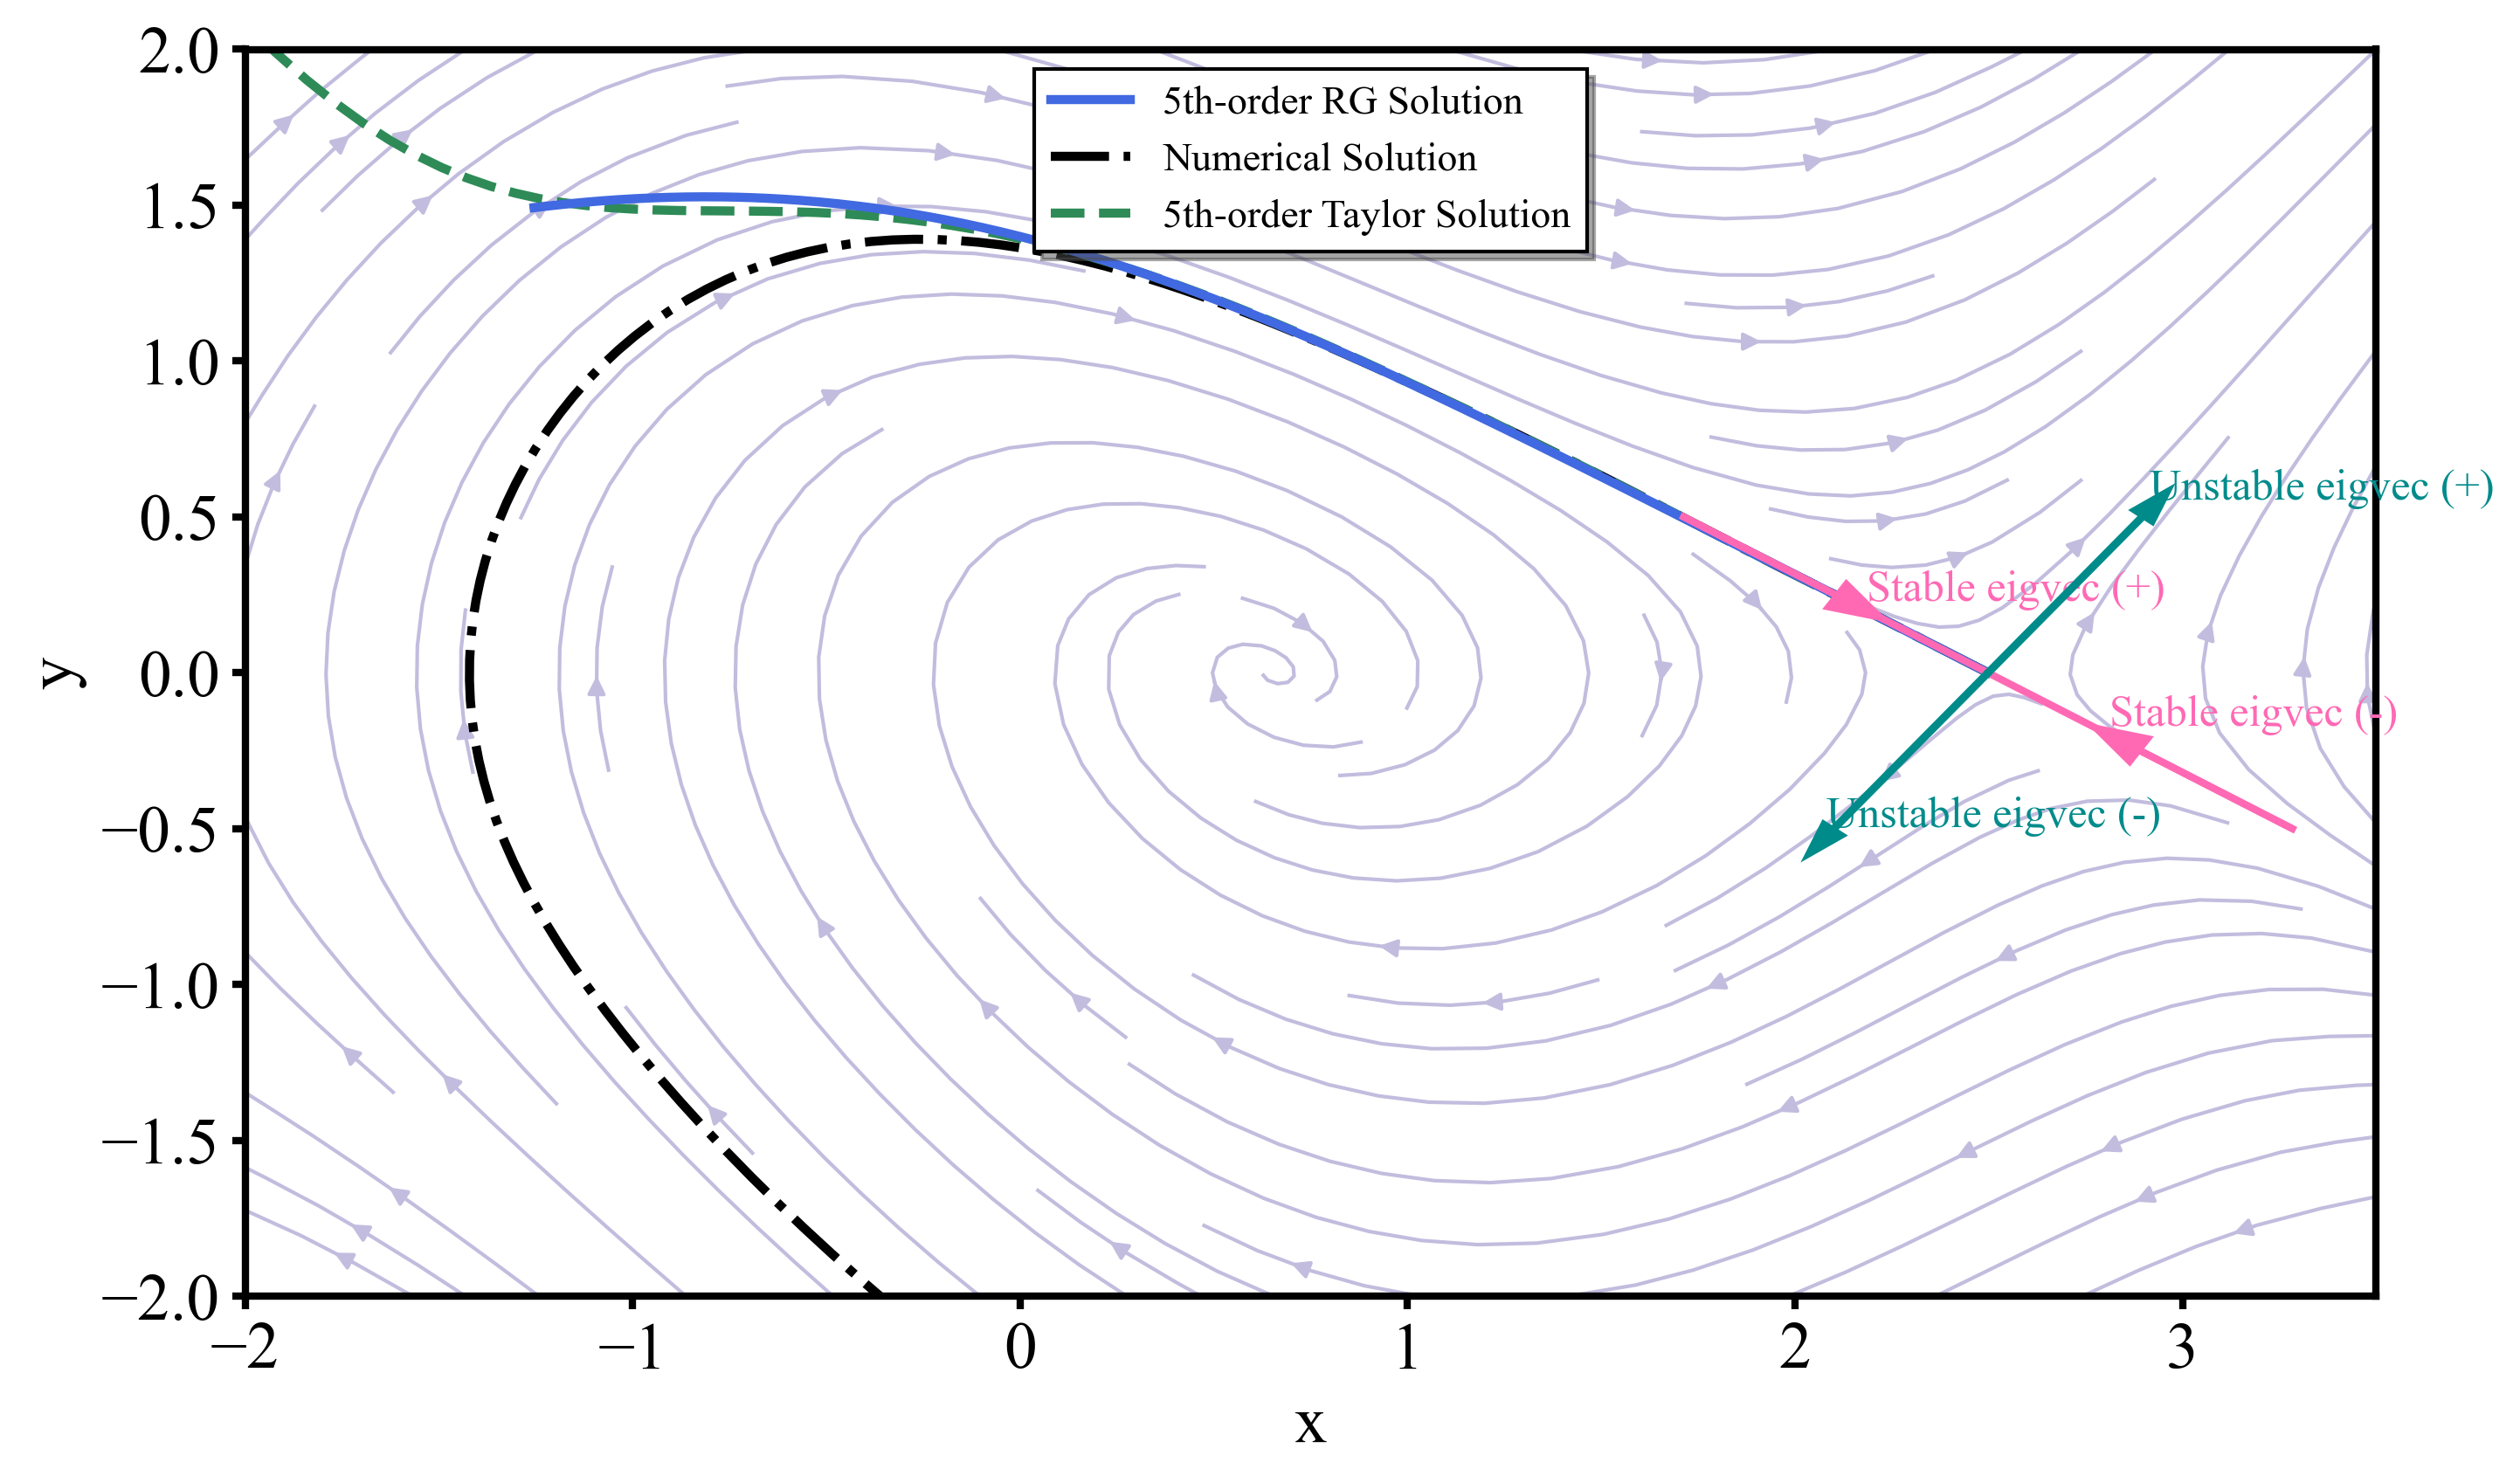

In [18]:
zw_funcs = create_zw_functions(zw_expr, epsilon_val)

# 使用符号表达式计算初始值
z0 = 0.001
w0 = 0
x0, y0 = transform_z_w_to_x_y(z0, w0)
xlim = (-2, 3.5)
ylim = (-2, 2)
# 数值积分时间范围
t_span = [0, 20]
t_eval = np.linspace(*t_span, 500)
t_span_long = [0, 13]
t_eval_long = np.linspace(*t_span_long, 1000)
# 求解数值解
num_sol = solve_ivp(original_ode_system, t_span, [x0, y0], t_eval=t_eval, method='RK45')
x_num = num_sol.y[0]
y_num = num_sol.y[1]
taylor_sol  = solve_ivp(taylor_ode_system, t_span, [x0, y0], t_eval=t_eval, method='RK45')
rg_sol = solve_ivp(rg_system, t_span_long, [z0], method='RK45', rtol=1e-12, atol=1e-12)
a_array = rg_sol.y[0]
x_rg, y_rg = rg_xy_func(a_array, zw_funcs)
# 流场线计算
x_grid, y_grid = np.meshgrid(np.linspace(xlim[0],xlim[1], 20), np.linspace(ylim[0],ylim[1], 20))
dx_grid = y_grid
dy_grid = I_val - np.sin(x_grid) - (alpha_val * np.cos(x_grid) - D_val) * y_grid

plt.figure(figsize=(10, 6))

# 1. 摄动解
plt.plot(x_rg, y_rg , label=f'{rg_order}th-order RG Solution', color='royalblue', linewidth=2.5, zorder=5)

# 2. 数值解
plt.plot(x_num,y_num, linestyle='-.', label='Numerical Solution', color='black', linewidth=2.5)

# 3. 泰勒展开对比
plt.plot(taylor_sol.y[0],taylor_sol.y[1], linestyle='--', label=f'{tl_order}th-order Taylor Solution', color='seagreen', linewidth=2.5)


# 4. 相空间流场
plt.streamplot(x_grid, y_grid, dx_grid, dy_grid, color='#c2bdde', density=1, linewidth=1, arrowsize=1,zorder=0)
arrow_scale = 0.5

# 计算并填充面积
y_values = num_sol.y[1]
max_y_index = np.argmax(y_values)
xm = num_sol.y[0][max_y_index]  # 数值解y最大值对应的x坐标

# 截取数值解在[xm, xs_val]区间的部分（注意时间序列方向）
num_valid_mask = (num_sol.y[0] >= xm) & (num_sol.y[0] <= x0)
x_num_segment = num_sol.y[0][num_valid_mask]
y_num_segment = num_sol.y[1][num_valid_mask]

# 截取RG解在[xm, xs_val]区间的部分（注意RG解x的单调性）
rg_valid_mask = (x_rg >= xm) & (x_rg <= x0)
x_rg_segment = x_rg[rg_valid_mask]
y_rg_segment = y_rg[rg_valid_mask]

# 确保数据点按x升序排列
x_num_segment, y_num_segment = zip(*sorted(zip(x_num_segment, y_num_segment)))
x_rg_segment, y_rg_segment = zip(*sorted(zip(x_rg_segment, y_rg_segment)))

# 使用精细插值处理反向y值

# 生成插值范围[xm, xs_val]
x_interp = np.linspace(xm, x0, 1000)

# 对数值解进行插值
f_num = interp1d(x_num_segment, y_num_segment, 
                kind='quadratic', 
                bounds_error=False,
                fill_value=(y_num_segment[0], y_num_segment[-1]))
y_num_interp = f_num(x_interp)

# 对RG解进行插值
f_rg = interp1d(x_rg_segment, y_rg_segment,
               kind='quadratic',
               bounds_error=False,
               fill_value=(y_rg_segment[0], y_rg_segment[-1]))
y_rg_interp = f_rg(x_interp)

# 确定上下边界
upper_curve = np.maximum(y_num_interp, y_rg_interp)
lower_curve = np.minimum(y_num_interp, y_rg_interp)

# 稳定流形正向：箭头从外侧指向鞍点
# 计算线段起点和终点
arrow_scale = 0.5
end_x = xs_val 
end_y = ys_val
start_x = xs_val + vec_unstable_val[0]*arrow_scale
start_y = ys_val + vec_unstable_val[1]*arrow_scale
# --- 绘制线段（不带箭头）---
plt.plot([start_x, end_x], [start_y, end_y],color='#FF69B4', linewidth=2, zorder=10)
# --- 在中间位置绘制箭头 ---
mid_x = (start_x + end_x) * 0.5  # 中点 x
mid_y = (start_y + end_y) * 0.5  # 中点 y
# 箭头方向（从中点指向终点）
arrow_dx = -vec_unstable_val[0] * arrow_scale * 0.5
arrow_dy = -vec_unstable_val[1] * arrow_scale * 0.5
plt.arrow(
    start_x, start_y,  # 箭头起点（中点）
    arrow_dx, arrow_dy,  # 方向（指向终点）
    width=0.01, head_width=0.1, head_length=0.15,
    fc='#FF69B4', ec='#FF69B4', zorder=5)
 
plt.text( mid_x + arrow_dx * 0.2, mid_y + arrow_dy * 0.2,
    'Stable eigvec (+)', color='#FF69B4', fontsize=12, ha='left', va='bottom')

# 稳定流形负向
end_x = xs_val 
end_y = ys_val
start_x = xs_val - vec_unstable_val[0]*arrow_scale
start_y = ys_val - vec_unstable_val[1]*arrow_scale
# --- 绘制线段（不带箭头）---
plt.plot([start_x, end_x], [start_y, end_y],color='#FF69B4', linewidth=2, zorder=10)
# --- 在中间位置绘制箭头 ---
mid_x = (start_x + end_x) * 0.5  # 中点 x
mid_y = (start_y + end_y) * 0.5  # 中点 y
# 箭头方向（从中点指向终点）
arrow_dx = vec_unstable_val[0] * arrow_scale * 0.5
arrow_dy = vec_unstable_val[1] * arrow_scale * 0.5
plt.arrow(
    start_x, start_y,  # 箭头起点（中点）
    arrow_dx, arrow_dy,  # 方向（指向终点）
    width=0.01, head_width=0.1, head_length=0.15,
    fc='#FF69B4', ec='#FF69B4', zorder=5)
 
plt.text( mid_x + arrow_dx * 0.2, mid_y + arrow_dy * 0.2,
    'Stable eigvec (-)', color='#FF69B4', fontsize=12, ha='left', va='bottom')

# 不稳定流形正向：从鞍点出发
plt.arrow(xs_val, ys_val, vec_stable_val[0]*arrow_scale, vec_stable_val[1]*arrow_scale,
          width=0.012, head_width=0.07, head_length=0.12, fc='#008B8B', ec='#008B8B', zorder=10)
plt.text(xs_val + vec_stable_val[0]*arrow_scale*1.05, ys_val + vec_stable_val[1]*arrow_scale*1.05,
         'Unstable eigvec (+)', color='#008B8B', fontsize=12, ha='left', va='bottom')

# 不稳定流形负向：从鞍点出发
plt.arrow(xs_val, ys_val, -vec_stable_val[0]*arrow_scale, -vec_stable_val[1]*arrow_scale,
          width=0.012, head_width=0.07, head_length=0.12, fc='#008B8B', ec='#008B8B', zorder=10)
plt.text(xs_val - vec_stable_val[0]*arrow_scale*1.05, ys_val - vec_stable_val[1]*arrow_scale*1.05,
         'Unstable eigvec (-)', color='#008B8B', fontsize=12, ha='left', va='bottom')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(frameon=True,edgecolor='black',fancybox=False,shadow=True,)
plt.show()